In [1]:
import numpy as np
import pandas as pd
import gudhi as gd
from cleaner import cleaner
import datetime
from halvingdates import *

In [2]:
df = pd.read_csv('data/btcall.csv', index_col='Date', parse_dates=True,).sort_index()
df = cleaner(df).astype('float')

In [3]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,80.0,0.00
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.00
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.00
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.00
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.00
...,...,...,...,...,...,...
2022-06-23,21100.7,19967.3,21189.8,19907.5,110700.0,5.68
2022-06-24,21226.9,21100.9,21488.7,20743.9,104560.0,0.60
2022-06-25,21489.9,21226.9,21553.4,20917.5,66630.0,1.24


# Separating between Halving Dates

I create new columns, each corresponding to the halvings.

In [4]:
half1 = df[halvingdates[0]:halvingdates[1]][['Price']].rename({'Price':'x'}, axis=1)
half2 = df[halvingdates[1]:halvingdates[2]][['Price']].rename({'Price':'y'}, axis=1)
half3 = df[halvingdates[2]:][['Price']].rename({'Price':'z'}, axis=1)

In [5]:
half = pd.concat([half1.reset_index(drop=True), half2.reset_index(drop=True), half3.reset_index(drop=True)], axis=1)

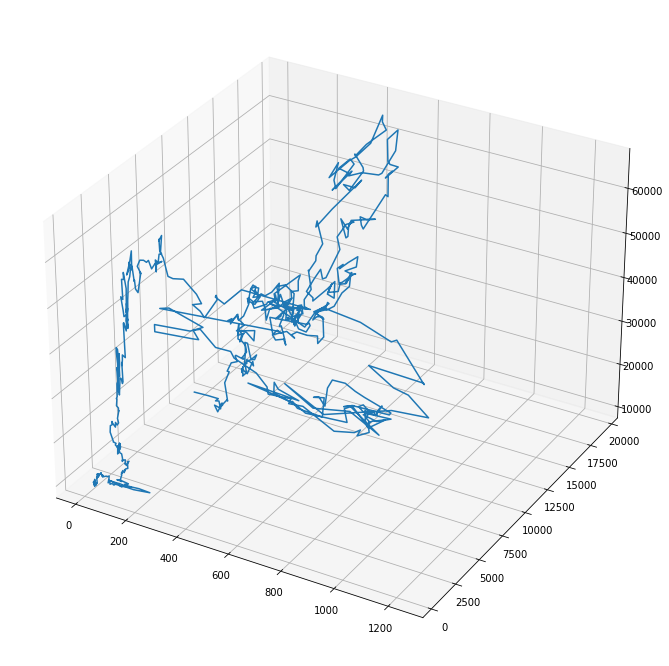

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')
plt.plot(half.x, half.y, half.z)

## Persistent Homology

In [7]:
# rips complex
# not used for now
#rips = gd.RipsComplex(points = data_A_sample, max_edge_length = 0.2)
#ripssimplex = rips.create_simplex_tree(max_dimension = 3) 
#ripsgen = ripssimplex.get_filtration()

In [8]:
alpha_complex = gd.AlphaComplex(points = half.dropna().values)
st_alpha = alpha_complex.create_simplex_tree()
st_alpha.persistence()
persist = st_alpha.persistence_intervals_in_dimension(1)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

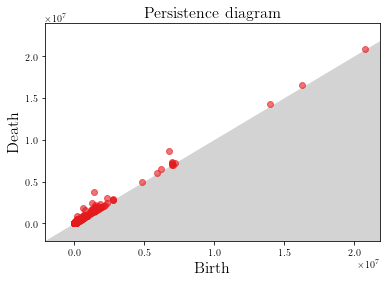

In [9]:
gd.plot_persistence_diagram(persist)

<AxesSubplot:title={'center':'Persistence barcode'}>

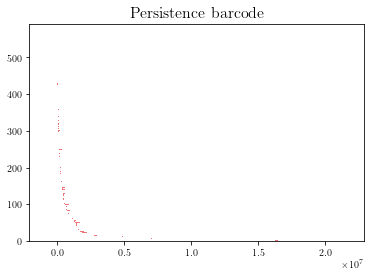

In [10]:
gd.persistence_graphical_tools.plot_persistence_barcode(persist)

In [11]:
persist

array([[6.61150000e+01, 7.06529014e+01],
       [8.96925000e+01, 9.66127155e+01],
       [9.38825000e+01, 1.01584631e+02],
       ...,
       [1.39729842e+07, 1.42937216e+07],
       [1.62624543e+07, 1.65127603e+07],
       [2.08077956e+07, 2.08079157e+07]])

In [12]:
def persnorm(df):
    alpha_complex = gd.AlphaComplex(points = df.dropna().values)
    st_alpha = alpha_complex.create_simplex_tree()
    barcode = st_alpha.persistence()
    persist = st_alpha.persistence_intervals_in_dimension(1)
    p = 1
    res = 0
    for i in persist:
        k = i.mean()
        res += (2*k**(p+1)/(p+1))**(1/p)
    return res

def getph(df):
    alpha_complex = gd.AlphaComplex(points = df.dropna().values)
    st_alpha = alpha_complex.create_simplex_tree()
    st_alpha.persistence()
    return st_alpha.persistence_intervals_in_dimension(1)

## Rolling Window

I will use a 7 day and 50 day rolling window and compute the persistence norm.

In [13]:
rolling50 = []
for i in range(len(half)-50):
    rolling50.append(persnorm(half[i:i+50]))
rolling7 = []
for i in range(len(half)-7):
    rolling7.append(persnorm(half[i:i+7]))

Alpha_complex_3d create_complex - no triangulation as points are on a 2d plane
Alpha_complex_3d create_complex - no triangulation as points are on a 2d plane
Alpha_complex_3d create_complex - no triangulation as points are on a 2d plane
Alpha_complex_3d create_complex - no triangulation as points are on a 2d plane
Alpha_complex_3d create_complex - no triangulation as points are on a 2d plane
Alpha_complex_3d create_complex - no triangulation as points are on a 2d plane


In [14]:
rolling50 = np.array(rolling50)
rolling7 = np.array(rolling7)

In [15]:
adjustedr50 = rolling50[rolling50!=0]

In [16]:
rolling50.mean(), rolling50.std()

(6134802521424.071, 20792909008566.082)

In [17]:
adjustedr50.mean(), adjustedr50.std()

(10737888501276.543, 26595418154219.957)

In [18]:
np.log(adjustedr50).mean(), np.log(adjustedr50).std()

(25.66693065936978, 4.95464410907983)

## Plots

<AxesSubplot:>

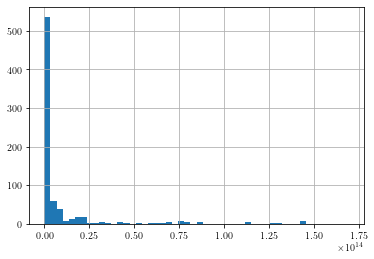

In [19]:
pd.Series(adjustedr50).hist(bins=50)

<AxesSubplot:>

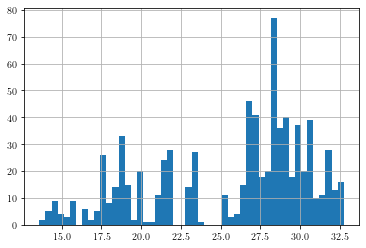

In [20]:
np.log(pd.Series(adjustedr50)).hist(bins=50)

Find the peak days and lowest drop days from the halving date

<AxesSubplot:>

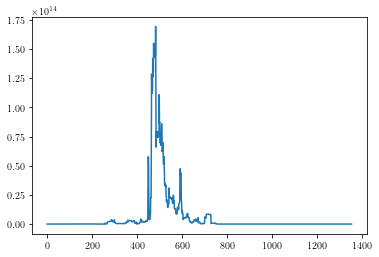

In [21]:
pd.Series(rolling50).plot()

<AxesSubplot:>

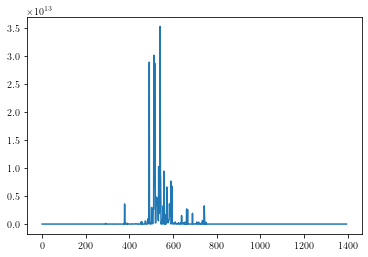

In [22]:
pd.Series(rolling7).plot()

<AxesSubplot:>

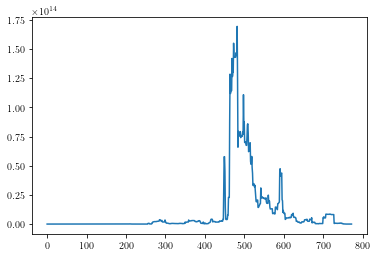

In [23]:
pd.Series(rolling50[rolling50!=0]).plot()

<AxesSubplot:>

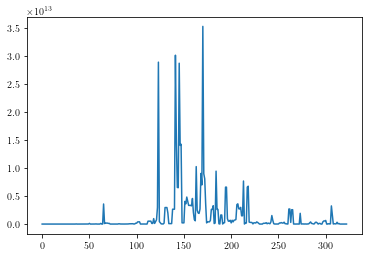

In [24]:
pd.Series(rolling7[rolling7!=0]).plot()

<AxesSubplot:>

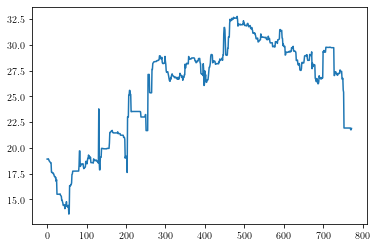

In [25]:
np.log(pd.Series(adjustedr50)).plot()

<AxesSubplot:>

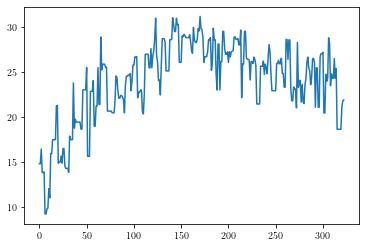

In [26]:
np.log(pd.Series(rolling7[rolling7!=0])).plot()

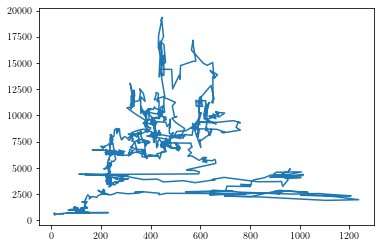

In [27]:
plt.plot(half.x, half.y)

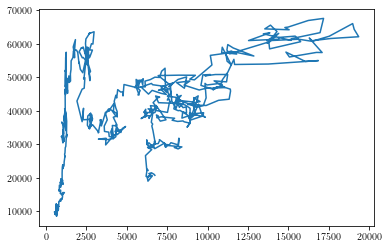

In [28]:
plt.plot(half.y, half.z)

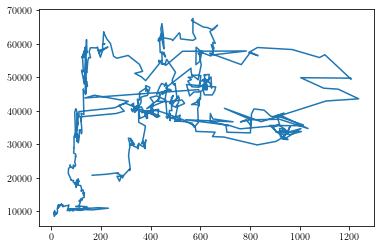

In [29]:
plt.plot(half.x, half.z)

In [30]:
rolling50.argmax()

482

<AxesSubplot:>

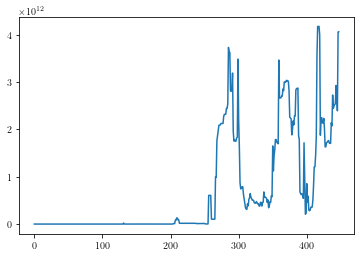

In [31]:
pd.Series(adjustedr50)[:448].plot()

<AxesSubplot:>

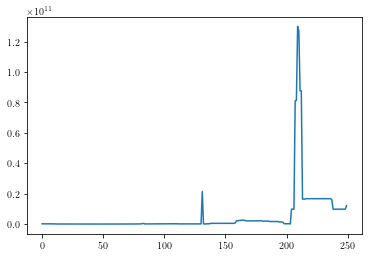

In [32]:
pd.Series(adjustedr50)[:250].plot()